<a href="https://colab.research.google.com/github/TanushGoel/Pump-It-Up/blob/master/Pump_It_Up_Water_Extra_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
pd.options.mode.use_inf_as_na = False
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# MICE was pretty bad at guessing construction year
train = pd.read_csv('PumpItUpTokenizedCleanedMICE_train.csv')
train.status_group = train.status_group.astype(int)
target = train.status_group
train_id = train.id
train = train.drop('id', axis=1)
train.public_meeting = np.round((train.public_meeting-0.25)).astype(int)
train.permit = np.round((train.permit-0.175)).astype(int)
train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,6000.0,40616,0,1390,0,34.938093,-9.856322,0,0,0,0,0,11,5,0,0,109,1,0,0,1999.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.0,41339,1,1399,1,34.698766,-2.147466,1,0,1,1,1,20,2,1,1,280,1,1,1,2010.000000,0,0,0,1,0,1,1,0,0,1,1,1,1,1,0,0,1
2,25.0,41330,2,686,2,37.460664,-3.821329,2,0,2,2,2,21,4,2,2,250,1,0,1,2009.000000,0,0,0,0,0,2,2,0,0,0,0,2,2,1,1,0,1
3,0.0,41302,3,263,3,38.486161,-11.155298,3,0,3,3,3,90,63,3,3,58,1,0,1,1986.000000,1,1,1,0,0,1,1,0,0,2,2,3,3,0,1,0,-1
4,0.0,40737,4,0,4,31.130847,-1.825359,4,0,1,4,4,18,1,4,4,0,1,-1,1,1684.993408,0,0,0,2,1,1,1,0,0,3,3,1,1,1,0,0,1


In [4]:
test = pd.read_csv('PumpItUpTokenizedCleanedMICE_test.csv')
test_id = test.id
test = test.drop('id', axis=1)
test.public_meeting = np.round((test.public_meeting-0.25)).astype(int)
test.permit = np.round((test.permit-0.175)).astype(int)
test.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,0.0,41309,162,1996,340,35.290799,-4.059696,37400,0,4,10942,2,21,3,37,573,321,1,8,1,2012.0,5,5,3,8,3,1,1,0,0,3,3,1,1,1,3,2
1,0.0,41309,20,1569,5,36.656709,-3.309214,37401,0,2,19287,16,2,2,26,367,300,1,0,1,2000.0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0
2,0.0,41306,-1,1567,-1,34.767863,-5.004344,21518,0,4,7343,18,13,2,32,647,500,1,0,1,2010.0,5,5,3,0,0,1,1,0,0,1,1,1,1,1,3,2
3,0.0,41296,143,267,129,38.058046,-9.418672,37402,0,3,5578,14,80,43,105,1795,250,1,0,1,1987.0,5,5,3,0,0,3,3,0,0,2,2,5,5,0,3,2
4,500.0,41360,1036,1260,1131,35.006123,-10.950412,2984,0,3,2889,9,10,3,97,653,60,1,4,1,2000.0,0,0,0,4,0,6,6,0,0,0,0,0,0,0,0,0


In [5]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 17.22 MB
Memory usage after optimization is: 3.23 MB
Decreased by 81.2%


In [6]:
test = reduce_mem_usage(test)

Memory usage of dataframe is 4.19 MB
Memory usage after optimization is: 0.79 MB
Decreased by 81.1%


In [0]:
train['dist'] = train.longitude ** 2 + train.latitude ** 2
test['dist'] = test.longitude ** 2 + test.latitude ** 2

In [0]:
train['dist2'] = train.gps_height ** 2 + train.dist
test['dist2'] = test.gps_height ** 2 + test.dist

In [0]:
train['wpt_dist_min'] = train.groupby('wpt_name')['dist'].transform('min')
train['wpt_dist_min2'] = train.groupby('wpt_name')['dist2'].transform('min')

test['wpt_dist_min'] = test.groupby('wpt_name')['dist'].transform('min')
test['wpt_dist_min2'] = test.groupby('wpt_name')['dist2'].transform('min')

train['wpt_dist_max'] = train.groupby('wpt_name')['dist'].transform('max')
train['wpt_dist_max2'] = train.groupby('wpt_name')['dist2'].transform('max')

test['wpt_dist_max'] = test.groupby('wpt_name')['dist'].transform('max')
test['wpt_dist_max2'] = test.groupby('wpt_name')['dist2'].transform('max')

In [0]:
train['construct_record_min'] = train.groupby('construction_year')['date_recorded'].transform('min')
test['construct_record_min'] = test.groupby('construction_year')['date_recorded'].transform('min')

train['construct_record_max'] = train.groupby('construction_year')['date_recorded'].transform('max')
test['construct_record_max'] = test.groupby('construction_year')['date_recorded'].transform('max')

train['construct_record'] = (train.date_recorded - train.construction_year)
train['construct_record_2'] = (train.date_recorded - train.construction_year) / train.construction_year

test['construct_record'] = (test.date_recorded - test.construction_year)
test['construct_record_2'] = (test.date_recorded - test.construction_year) / test.construction_year

Text(0.5, 1.0, 'Variable Correlations')

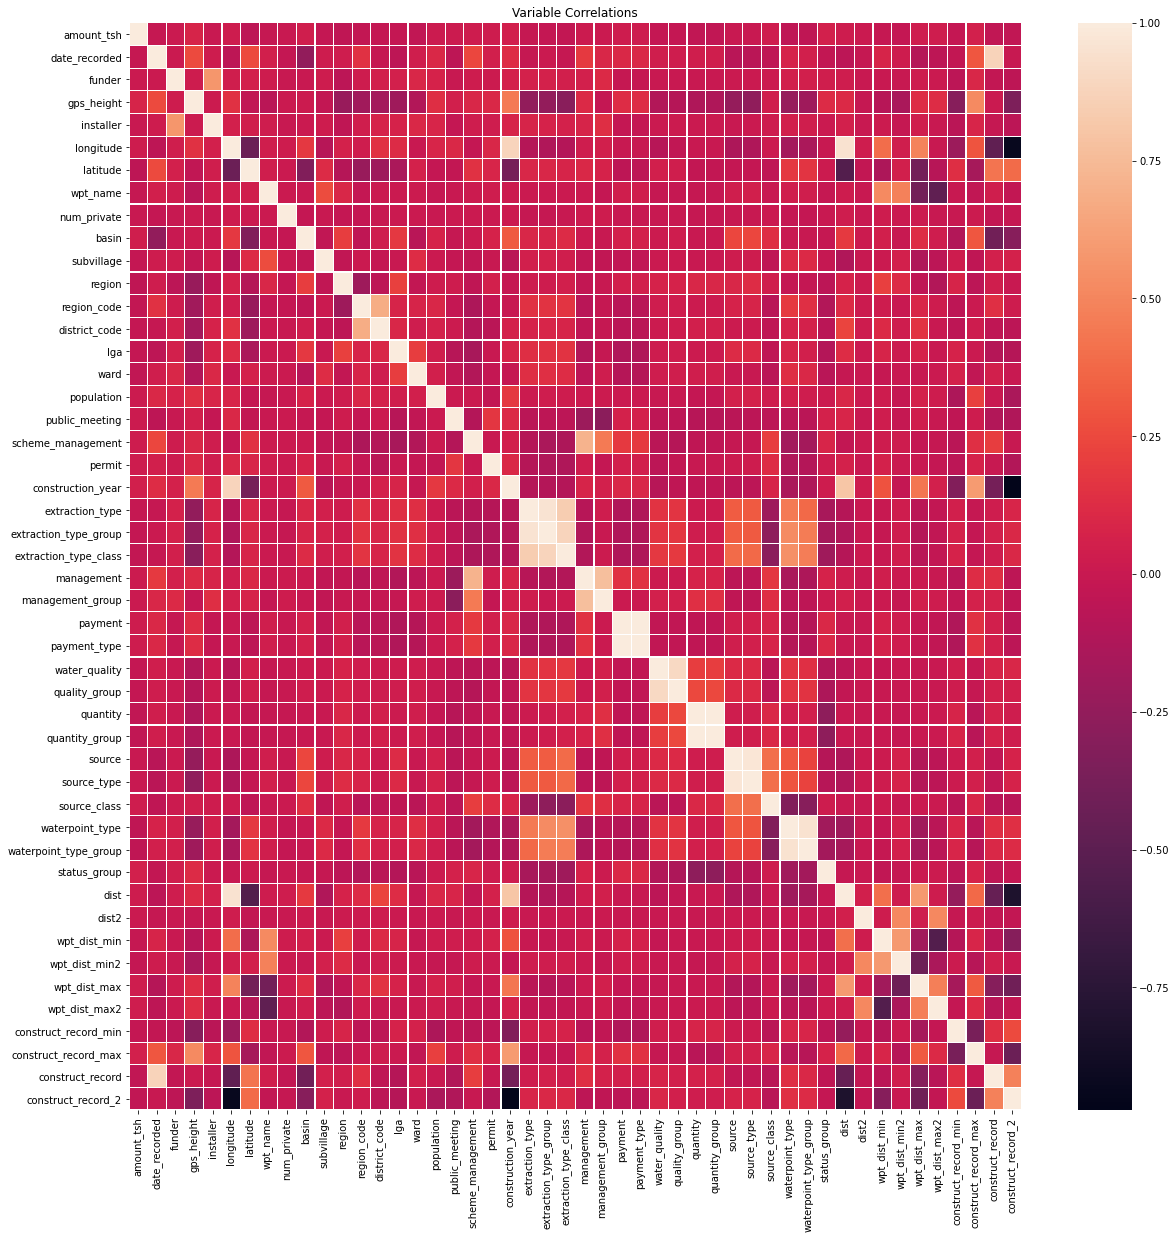

In [11]:
import seaborn as sns
correlations = train.corr()
fig, ax = plt.subplots(figsize=(20,20))
corr_heat = sns.heatmap(correlations, linewidths=0.125, ax=ax)
plt.title('Variable Correlations')

In [12]:
from sklearn.decomposition import PCA

def principal_component_analyze(df):

    extraction_type = df.extraction_type
    extraction_type_group = df.extraction_type_group
    extraction_type_class = df.extraction_type_class
    
    extraction = pd.DataFrame(data=list(zip(extraction_type, extraction_type_group, extraction_type_class)),
                  columns = ['extraction_type', 'extraction_type_group', 'extraction_type_class'])

    pca_extraction = PCA(n_components=1)
    extractpca = pca_extraction.fit_transform(extraction)
    df['extraction'] = extractpca
    print("Extraction EVR", pca_extraction.explained_variance_ratio_)
    
    
    management = df.management
    management_group = df.management_group
    
    manage = pd.DataFrame(data=list(zip(management, management_group)),
                  columns = ['management', 'management_group'])

    pca_manage = PCA(n_components=1)
    managementpca = pca_manage.fit_transform(manage)
    df['manage'] = managementpca
    print("Management EVR", pca_manage.explained_variance_ratio_)
    
    
    payment = df.payment
    payment_type = df.payment_type
    
    pay = pd.DataFrame(data=list(zip(payment, payment_type)),
                  columns = ['payment', 'payment_type'])

    pca_pay = PCA(n_components=1)
    paypca = pca_pay.fit_transform(pay)
    df['pay'] = paypca
    print("Payment EVR", pca_pay.explained_variance_ratio_)
    
    
    water_quality = df.water_quality
    quality_group = df.quality_group
    
    quality = pd.DataFrame(data=list(zip(water_quality, quality_group)),
                  columns = ['water_quality', 'quality_group'])

    pca_qual = PCA(n_components=1)
    qualpca = pca_qual.fit_transform(quality)
    df['qual'] = qualpca
    print("Quality EVR", pca_qual.explained_variance_ratio_)
    
    
    quantity = df.quantity
    quantity_group = df.quantity_group
    
    quant = pd.DataFrame(data=list(zip(quantity, quantity_group)),
                  columns = ['quantity', 'quantity_group'])

    pca_quant = PCA(n_components=1)
    quantpca = pca_quant.fit_transform(quant)
    df['manage'] = quantpca
    print("Quantity EVR", pca_quant.explained_variance_ratio_)
    
    
    source = df.source
    source_type = df.source_type
    
    ss = pd.DataFrame(data=list(zip(source, source_type)),
                  columns = ['source', 'source_type'])

    pca_ss = PCA(n_components=1)
    sspca = pca_ss.fit_transform(ss)
    df['ss'] = sspca
    print("Source EVR", pca_ss.explained_variance_ratio_)
    
    
    waterpoint_type = df.waterpoint_type
    waterpoint_type_group = df.waterpoint_type_group
    
    waterpoint = pd.DataFrame(data=list(zip(waterpoint_type, waterpoint_type_group)),
                  columns = ['waterpoint_type', 'waterpoint_type_group'])

    pca_waterpoint = PCA(n_components=1)
    waterpointpca = pca_waterpoint.fit_transform(waterpoint)
    df['waterpoint'] = waterpointpca
    print("Waterpoint EVR", pca_waterpoint.explained_variance_ratio_)
    
    
    district_code = df.district_code
    region_code = df.region_code
    
    code = pd.DataFrame(data=list(zip(district_code, region_code)),
                  columns = ['district_code', 'region_code'])

    pca_code = PCA(n_components=1)
    codepca = pca_code.fit_transform(code)
    df['code'] = codepca
    print("Code EVR", pca_code.explained_variance_ratio_)
    
    
    #df = df.drop(['extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'district_code', 'region_code', 
                 #'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'waterpoint_type', 'waterpoint_type_group'], axis=1)
    
    return df
  
train = principal_component_analyze(train)
test = principal_component_analyze(test)

Extraction EVR [0.95678236]
Management EVR [0.96039072]
Payment EVR [1.]
Quality EVR [0.95462718]
Quantity EVR [1.]
Source EVR [0.98684648]
Waterpoint EVR [0.98064153]
Code EVR [0.89271392]
Extraction EVR [0.95597614]
Management EVR [0.9606198]
Payment EVR [1.]
Quality EVR [0.95550984]
Quantity EVR [1.]
Source EVR [0.98588773]
Waterpoint EVR [0.98080023]
Code EVR [0.89214725]


In [0]:
# We can completely remove the features of which the PCA is 1 because this means that they are the exact same values for every data point
# The other pairs/groups of features are still very similar but it might be useful to keep them anyways

train.drop("payment_type", axis = 1, inplace = True)
test.drop("payment_type", axis = 1, inplace = True)

train.drop("quantity_group", axis = 1, inplace = True)
test.drop("quantity_group", axis = 1, inplace = True)

In [14]:
!pip3 install pygeohash
import pygeohash as gh

  Created wheel for pygeohash: filename=pygeohash-1.2.0-py2.py3-none-any.whl size=6163 sha256=7f5a51a5aaa7c56a08850782bc9734d6a1cb7ce719b65c35120535c21fe0a656
  Stored in directory: /root/.cache/pip/wheels/3f/5f/14/989d83a271207dda28232746d63e737a2dbd88ea7f7a9db807
Successfully built pygeohash


In [15]:
train['geohash'] = train.apply(lambda x: gh.encode(x.latitude, x.longitude, precision=2), axis=1)
test['geohash'] = test.apply(lambda x: gh.encode(x.latitude, x.longitude, precision=2), axis=1)

# factorize
geohash_factorized, mapping = train.geohash.factorize()
train.geohash = geohash_factorized

factorization = [i for i in range(0, len(mapping))]
  
factorization_map = dict(zip(mapping, factorization))
print(factorization_map)

test.geohash = test.geohash.map(factorization_map)

{'ky': 0, 'kz': 1, 'kx': 2, 'kw': 3, '7z': 4, 'kv': 5}


In [16]:
train['geohash2'] = train.apply(lambda y: gh.encode(y.latitude, y.longitude, precision=3), axis=1)
test['geohash2'] = test.apply(lambda y: gh.encode(y.latitude, y.longitude, precision=3), axis=1)

# factorize
geohash2_factorized, mapping2 = train.geohash2.factorize()
train.geohash2 = geohash2_factorized

factorization2 = [i for i in range(0, len(mapping2))]
  
factorization_map2 = dict(zip(mapping2, factorization2))
print(factorization_map2)

test.geohash2 = test.geohash2.map(factorization_map2)

{'ky0': 0, 'kz8': 1, 'kz6': 2, 'ky5': 3, 'kxw': 4, 'kz5': 5, 'kxr': 6, 'kxp': 7, 'kxv': 8, 'kye': 9, 'ky1': 10, 'kz2': 11, 'kww': 12, 'ky2': 13, 'kxx': 14, '7zz': 15, 'kxj': 16, 'kyc': 17, 'kyg': 18, 'kys': 19, 'kz1': 20, 'ky9': 21, 'kxm': 22, 'kz0': 23, 'kwr': 24, 'kwq': 25, 'kz3': 26, 'ky3': 27, 'kxy': 28, 'kxq': 29, 'kyf': 30, 'kvf': 31, 'kz4': 32, 'kzd': 33, 'kxn': 34, 'kyh': 35, 'kzb': 36, 'kyu': 37, 'ky4': 38, 'kyk': 39, 'kyd': 40, 'kxt': 41, 'ky8': 42, 'kyb': 43, 'kwz': 44, 'kvb': 45, 'ky6': 46, 'kwx': 47, 'kwt': 48, 'kwy': 49, 'ky7': 50, 'kvc': 51, 'kwv': 52, 'kz9': 53, 'kvg': 54, 'kz7': 55}


In [17]:
train['geohash3'] = train.apply(lambda z: gh.encode(z.latitude, z.longitude, precision=4), axis=1)
test['geohash3'] = test.apply(lambda z: gh.encode(z.latitude, z.longitude, precision=4), axis=1)

# factorize
geohash3_factorized, mapping3 = train.geohash3.factorize()
train.geohash3 = geohash3_factorized

factorization3 = [i for i in range(0, len(mapping3))]
  
factorization_map3 = dict(zip(mapping3, factorization3))
print(factorization_map3)

test.geohash3 = test.geohash3.map(factorization_map3)

{'ky0z': 0, 'kz8e': 1, 'kz6d': 2, 'ky52': 3, 'kxwj': 4, 'kz5u': 5, 'kxrd': 6, 'kxpp': 7, 'kxp6': 8, 'kxvb': 9, 'kyez': 10, 'ky17': 11, 'kz2j': 12, 'kz6m': 13, 'kz27': 14, 'kww2': 15, 'ky2s': 16, 'kxxk': 17, 'ky0x': 18, 'ky29': 19, '7zzz': 20, 'kz6b': 21, 'kxjn': 22, 'kz6t': 23, 'ky5z': 24, 'kxwn': 25, 'kz6v': 26, 'kycx': 27, 'kyg6': 28, 'ky28': 29, 'kys7': 30, 'kz6j': 31, 'ky21': 32, 'kz1m': 33, 'ky99': 34, 'kxmc': 35, 'kz6s': 36, 'ky25': 37, 'ky2u': 38, 'kz0v': 39, 'kz6h': 40, 'ky5c': 41, 'kwrg': 42, 'ky27': 43, 'kwqz': 44, 'ky24': 45, 'kz36': 46, 'kxwr': 47, 'kz5d': 48, 'kz5m': 49, 'kxjh': 50, 'kz6k': 51, 'kz0x': 52, 'kz0d': 53, 'ky2g': 54, 'ky2t': 55, 'ky3m': 56, 'ky2x': 57, 'ky2r': 58, 'kz8t': 59, 'kxjx': 60, 'kxy8': 61, 'ky2d': 62, 'kz67': 63, 'kz5k': 64, 'kxqu': 65, 'kyfb': 66, 'kxru': 67, 'kz8q': 68, 'kxwf': 69, 'ky96': 70, 'kxwk': 71, 'kycw': 72, 'kxjj': 73, 'ky5s': 74, 'kygd': 75, 'kz1n': 76, 'kxy3': 77, 'kxjr': 78, 'kxrw': 79, 'ky16': 80, 'kxre': 81, 'kz5g': 82, 'kz28': 83, '

In [0]:
del geohash3_factorized, mapping3, factorization3, factorization_map3, geohash2_factorized, mapping2, factorization2, factorization_map2, geohash_factorized, mapping, factorization, factorization_map

In [19]:
test.isnull().sum()

amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
water_quality            0
quality_group            0
quantity                 0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
dist                     0
dist2                    0
w

In [0]:
test.geohash3 = test.geohash3.fillna(-1)

In [21]:
test.isnull().sum()

amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
water_quality            0
quality_group            0
quantity                 0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
dist                     0
dist2                    0
w

In [22]:
import folium
from folium.plugins import HeatMap

# Train locations on Map
heatmap = folium.Map(location=[6.3690, 34.8888], zoom_start=4) # Tanzania longitude and latitude
heat_data = [[row['latitude'], row['longitude']] for index, row in train.iterrows()]
HeatMap(heat_data).add_to(heatmap)
heatmap

In [23]:
# Test locations on Map
heatmap = folium.Map(location=[6.3690, 34.8888], zoom_start=4) # Tanzania longitude and latitude
heat_data = [[row['latitude'], row['longitude']] for index, row in test.iterrows()]
HeatMap(heat_data).add_to(heatmap)
heatmap

In [0]:
del heatmap, heat_data

In [25]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 10.03 MB
Memory usage after optimization is: 5.50 MB
Decreased by 45.2%


In [26]:
test = reduce_mem_usage(test)

Memory usage of dataframe is 2.49 MB
Memory usage after optimization is: 1.36 MB
Decreased by 45.5%


Text(0.5, 1.0, 'Variable Correlations')

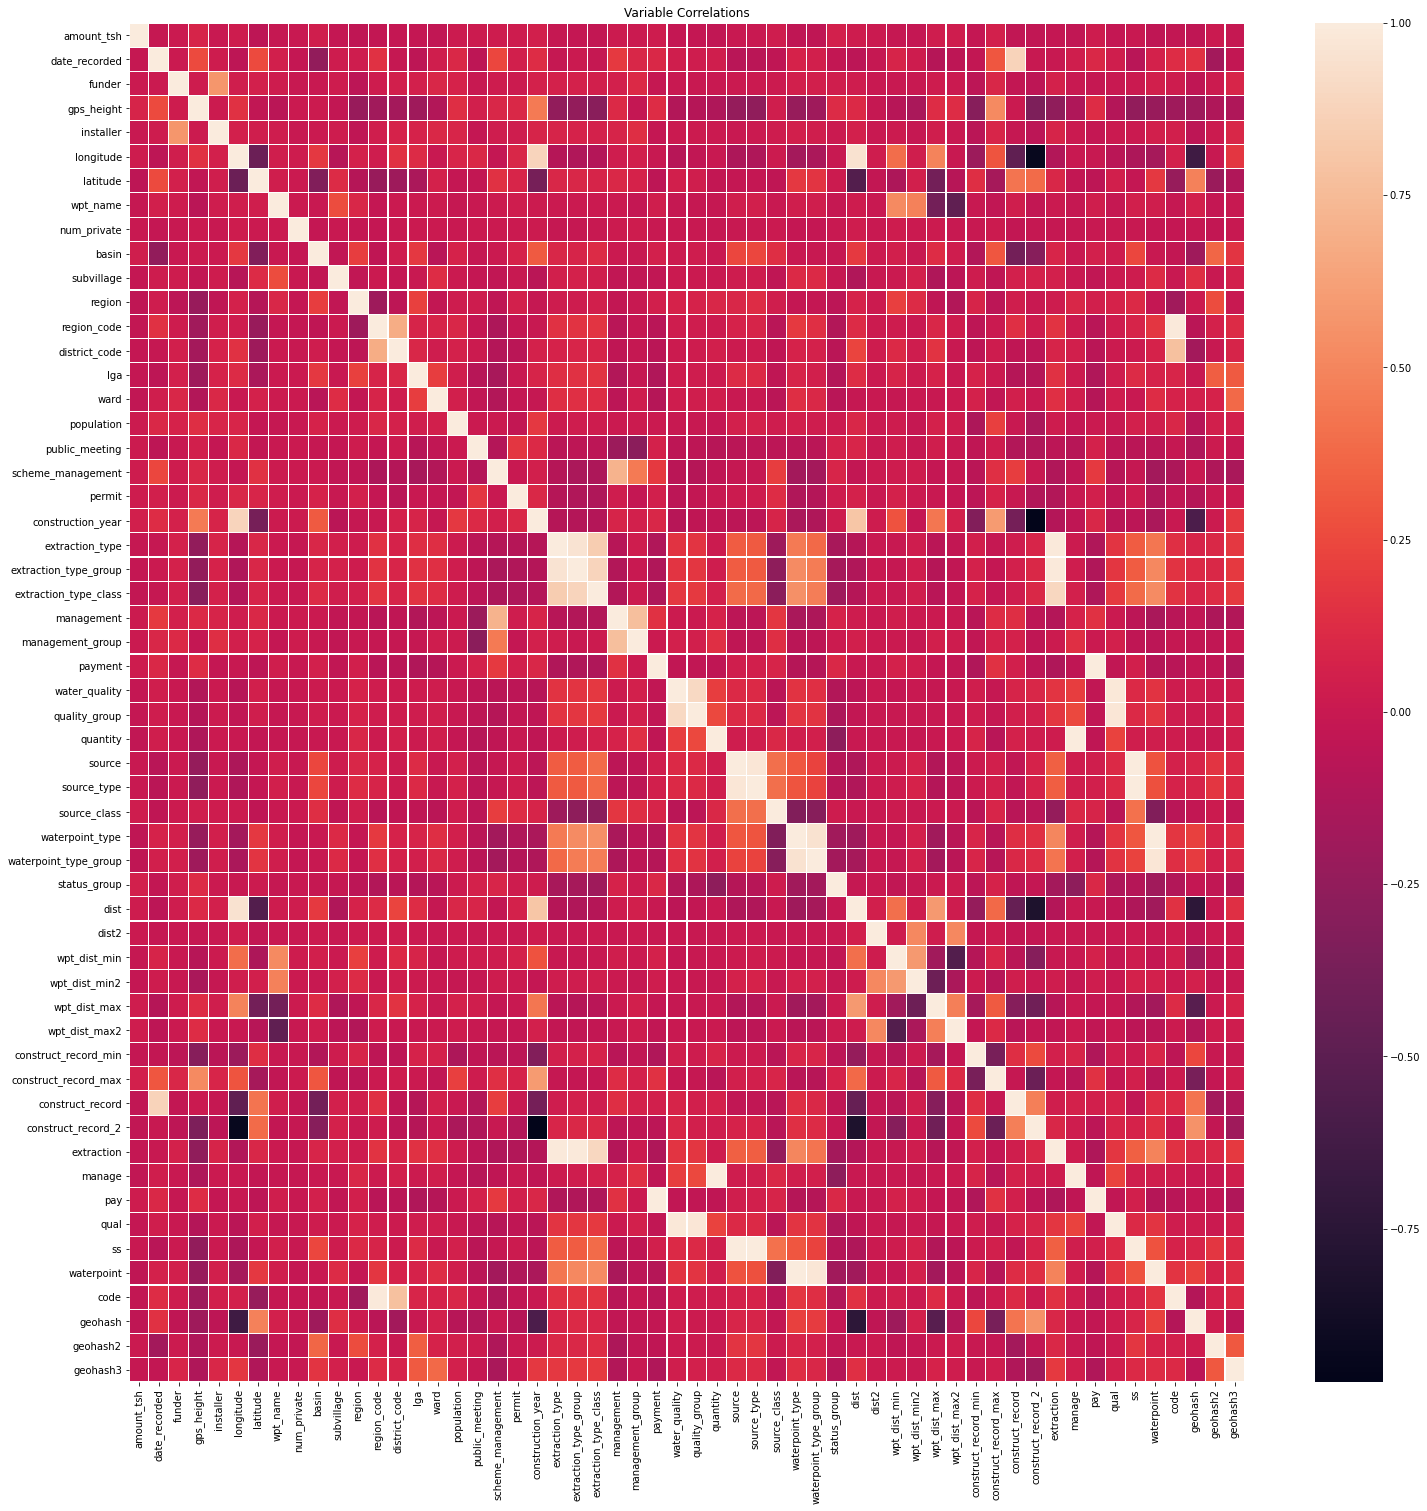

In [27]:
import seaborn as sns
correlations = train.corr()
fig, ax = plt.subplots(figsize=(25,25))
corr_heat = sns.heatmap(correlations, linewidths=0.125, ax=ax)
plt.title('Variable Correlations')

In [0]:
train = train.drop('status_group', axis=1)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=0.0025, random_state=1, stratify=target)

In [30]:
print('Train:', X_train.shape[0])
print('Valid:', X_valid.shape[0])

Train: 59251
Valid: 149


In [31]:
from sklearn.ensemble import ExtraTreesClassifier
extra_clf = ExtraTreesClassifier(n_estimators=500, n_jobs=-1, random_state=42)
extra_clf.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [32]:
from sklearn.metrics import accuracy_score
y_pred_extra = extra_clf.predict(X_valid)
print(f'Extra Trees with Accuracy: {accuracy_score(y_valid, y_pred_extra):1.3f}')

Extra Trees with Accuracy: 0.852


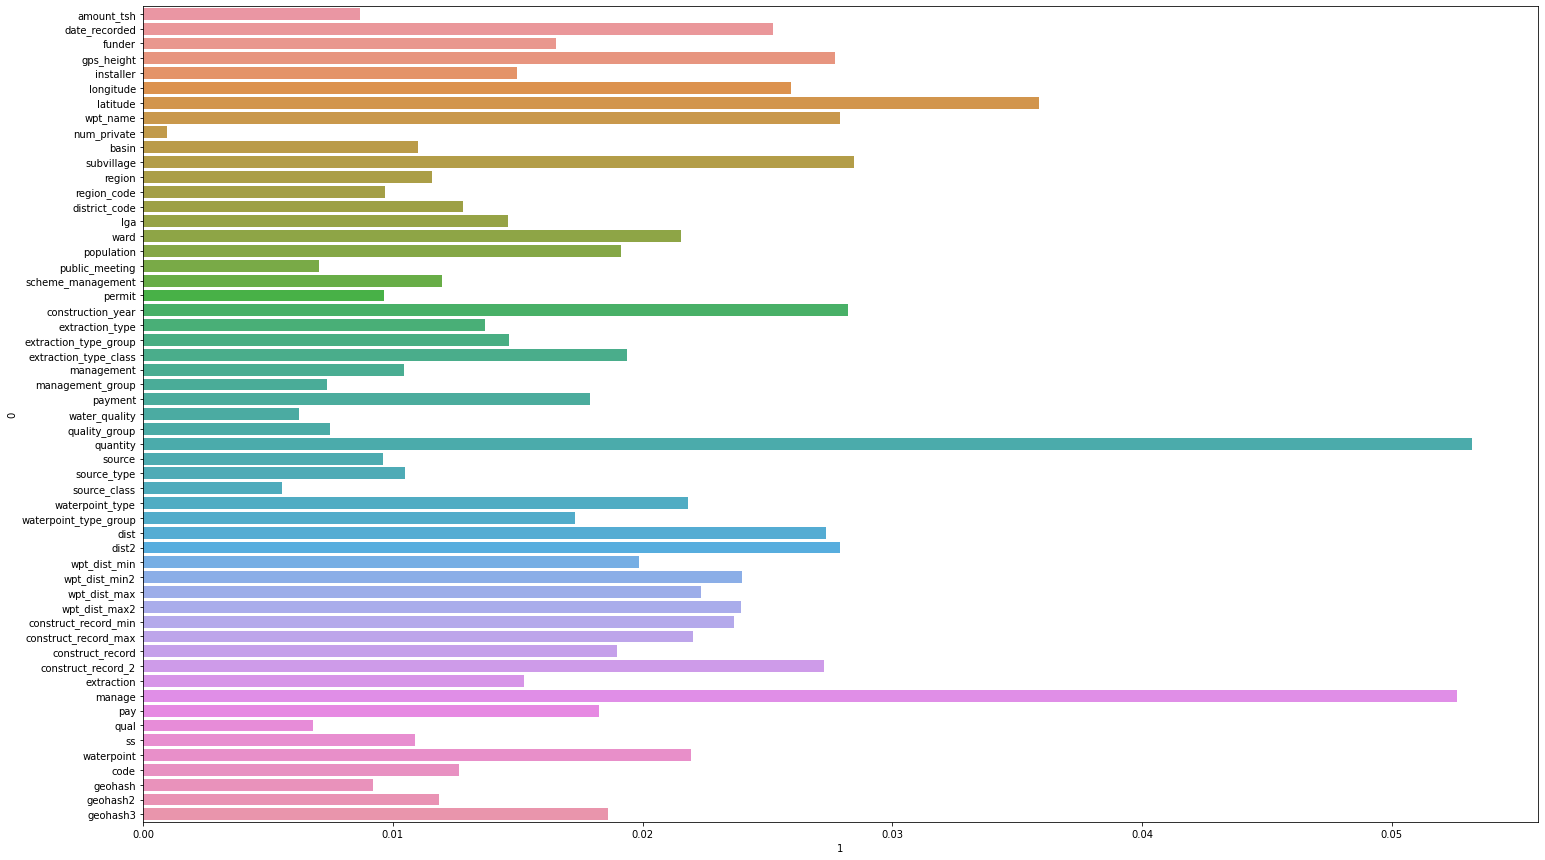

In [33]:
feature_stuff = pd.DataFrame(zip(train.columns, extra_clf.feature_importances_))
ax, f = plt.subplots(figsize=(25, 15))
sns.barplot(x=1, y=0, data=feature_stuff, label="Total")

In [0]:
del X_train, X_valid, y_train, y_valid, extra_clf

In [0]:
from sklearn.ensemble import ExtraTreesClassifier
final_clf = ExtraTreesClassifier(n_estimators=2750, n_jobs=-1, random_state=42)
final_clf.fit(train, target)

In [0]:
feature_stuff = pd.DataFrame(zip(train.columns, final_clf.feature_importances_))
ax, f = plt.subplots(figsize=(25, 15))
sns.barplot(x=1, y=0, data=feature_stuff, label="Total")

In [0]:
Y_pred = final_clf.predict(test)
submit = pd.DataFrame({
        "id": test_id.values,
        "status_group": Y_pred.ravel()
        })
submit.head(25)

In [0]:
submit.status_group = submit.status_group.map({-1.0:"non functional", 0.0:"functional needs repair", 1.0:"functional"})
submit.head(25)

In [0]:
submit.to_csv('PUMPITUP_SUBMISSION_8.csv', index=False)
from google.colab import files
files.download('PUMPITUP_SUBMISSION_8.csv')